<a href="https://colab.research.google.com/github/c3Zor/jupyter_lab/blob/master/signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pwd

/content


In [3]:
cd sample_data

/content/sample_data


In [4]:
!ls

anscombe.json		      german-traffic-signs   README.md
california_housing_test.csv   mnist_test.csv
california_housing_train.csv  mnist_train_small.csv


# New Section

In [5]:
#douwnloading data from bitbucket
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [6]:
!ls german-traffic-signs/

signnames.csv  test.p  train.p	valid.p


In [7]:
#importing libraries for signs
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D 
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
#for unpickle files in repository
import pickle
import pandas as pd
import random

Using TensorFlow backend.


In [0]:
#random seed to generate data allways the same
np.random.seed(0)

In [0]:
# with opens and closes the file in this case we open train.p, second argument is 
# what to do with the data opening in binary mode for reading ar writing 
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
# doing the same  for val data
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
# doing the same for test data
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

In [0]:
# out data is in dictiondary so we split it in two dictionaries
x_train, y_train = train_data['features'], train_data['labels']
x_val, y_val = val_data['features'], val_data['labels']
x_test, y_test = test_data['features'], test_data['labels']

In [0]:
#cheking if data import was sucessful we will check if all the pic data 
# matches label data we will use assert funciot
assert(x_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(x_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(x_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
# next we assert that our images are all the same size the check
#  if the tuble is 32x32x3 size
assert(x_train.shape[1:] == (32,32,3)), "The dimensions of the images ar not 32x32x3"
assert(x_val.shape[1:] == (32,32,3)), "The dimensions of the images ar not 32x32x3"
assert(x_test.shape[1:] == (32,32,3)), "The dimensions of the images ar not 32x32x3"

In [18]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [22]:
# lest plot and analize the data
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

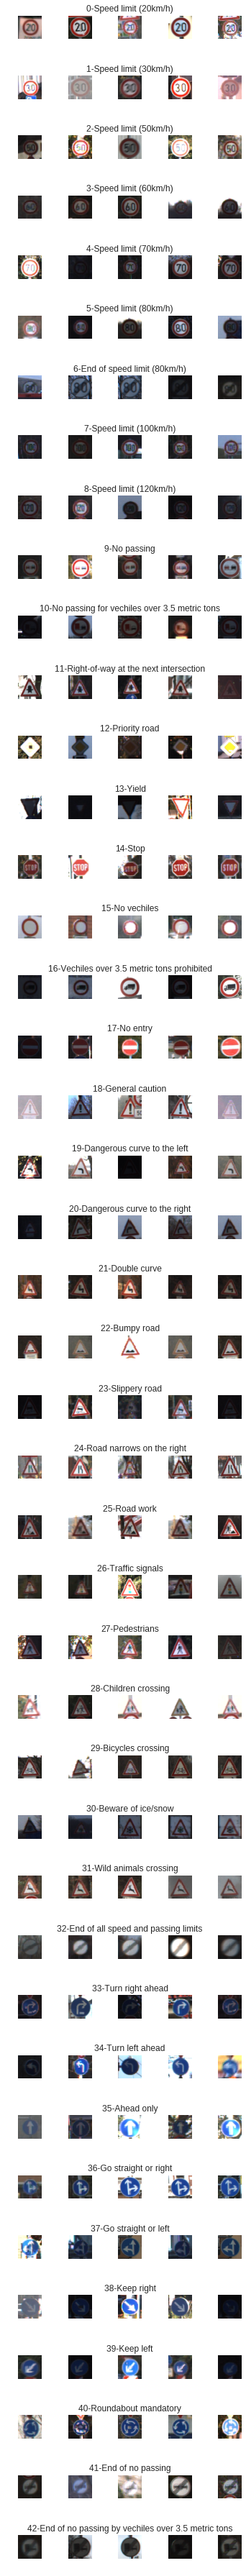

In [23]:
# builing a function to plot a couple of images in a training data of avery label
num_of_samples = []

cols = 5
num_classes = 43
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
  for j, row in data.iterrows():
    x_selected = x_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected)-1)),:,:], cmap=plt.get_cmap('gray'))
    axs[j][i].axis('off')
    if i == 2:
      axs[j][i].set_title(str(j) + '-' + row['SignName'])
      num_of_samples.append(len(x_selected))

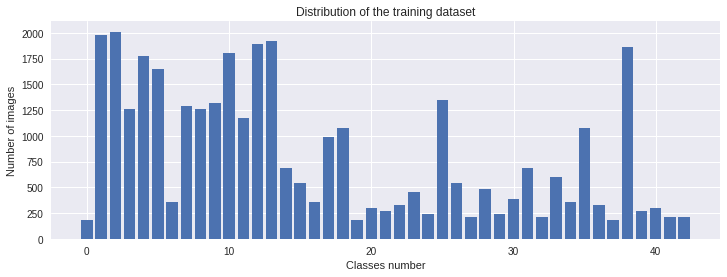

In [24]:
# we will visualize how training data is distributed between classes
plt.figure(figsize=(12,4))
plt.bar(range(0,num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel('Classes number')
plt.ylabel('Number of images')
plt.show()

(34799, 32, 32, 3)
36


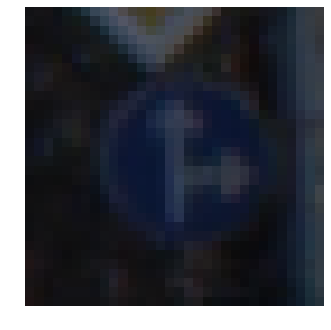

In [25]:
# we will preprocess out images for training DNN with opencv library
import cv2

plt.imshow(x_train[1000])
plt.axis('off')
print(x_train.shape)
print(y_train[1000])

(32, 32)


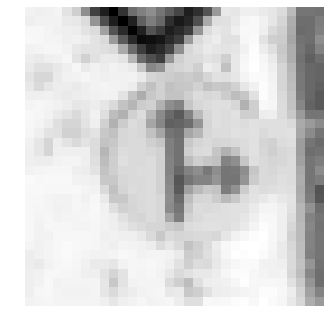

In [26]:
# preprocessing our image and changing it to gray scale
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(x_train[1000])
plt.imshow(img)
plt.axis('off')
print(img.shape)

(-0.5, 31.5, 31.5, -0.5)

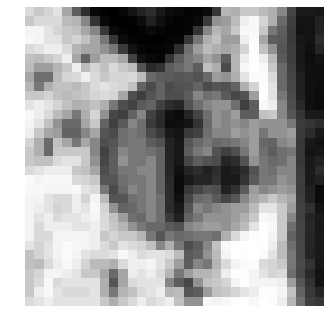

In [27]:
#histogram equalization standartize lighting for our images 
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img)
plt.axis('off')
#print(img.shape)

In [0]:
# creating a function to preprocces our whole dataset
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img
# using map to loop throug images on function preproccesing
# map returns a list so we store it in a list functiom
# later format this list as an array of images using np.array 
# and assinging it back to x_train values
x_train = np.array(list(map(preprocessing, x_train)))
# using the same functions on val data and test data
x_val = np.array(list(map(preprocessing, x_val)))
x_test = np.array(list(map(preprocessing, x_test)))


(34799, 32, 32)


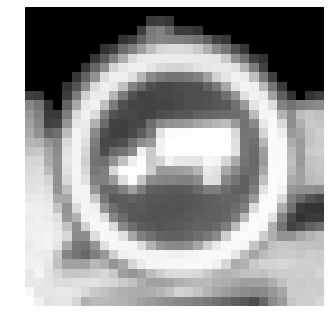

In [29]:
#lets plot our random images to see if everthing workout fine
plt.imshow(x_train[random.randint(0, len(x_train) - 1)])
plt.axis('off')
print(x_train.shape)

In [0]:
# adding the depth to our images so to use convelutional filters
x_train = x_train.reshape(34799, 32, 32, 1)
x_val = x_val.reshape(4410, 32, 32, 1)
x_test = x_test.reshape(12630, 32, 32, 1)

In [31]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [0]:
# last step to prepare our data is one hot encode 
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [33]:
print(y_train.shape)

(34799, 43)


In [0]:
def leNet_model():
  model = Sequential()
  # Conv2D 1 arg filters count second size of our filters
  # third input shape becouse it is 1 layer fourth is activation function 
  # we use relu
  model.add(Conv2D(30, (5,5), input_shape=(32,32,1), activation='relu'))
  # second layer 2D pooling 1st arg pooling size matrix
  model.add(MaxPooling2D(pool_size=(2,2)))
  # becouse our image is now 14x14x30 we will use smaller filters and less of them
  model.add(Conv2D(15, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  #Flatten the data so that we can feed it to fully connected layer
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(Adam(lr=0.2), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [45]:
# checking model summmary
model = leNet_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 30)        780       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 30)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 15)        4065      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 15)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 540)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               270500    
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)               0         
__________

In [46]:
# training our model
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), batch_size=400,verbose=1,shuffle=1)

Train on 34799 samples, validate on 4410 samples
Epoch 1/10
34799/34799 [==============================] - 2s 59us/step - loss: 15.1111 - acc: 0.0538 - val_loss: 15.3506 - val_acc: 0.0476
Epoch 2/10
34799/34799 [==============================] - 2s 49us/step - loss: 15.2427 - acc: 0.0543 - val_loss: 15.3506 - val_acc: 0.0476
Epoch 3/10
34799/34799 [==============================] - 2s 50us/step - loss: 15.2427 - acc: 0.0543 - val_loss: 15.3506 - val_acc: 0.0476
Epoch 4/10
34799/34799 [==============================] - 2s 49us/step - loss: 15.2427 - acc: 0.0543 - val_loss: 15.3506 - val_acc: 0.0476
Epoch 5/10
34799/34799 [==============================] - 2s 49us/step - loss: 15.2427 - acc: 0.0543 - val_loss: 15.3506 - val_acc: 0.0476
Epoch 6/10
34799/34799 [==============================] - 2s 50us/step - loss: 15.2427 - acc: 0.0543 - val_loss: 15.3506 - val_acc: 0.0476
Epoch 7/10
34799/34799 [==============================] - 2s 50us/step - loss: 15.2427 - acc: 0.0543 - val_loss: 15.3

In [0]:
plt.plot(history.history('loss'))